# Capítulo 5 – Detección de Anomalías con Análisis de Componentes Principales (PCA)

El **Análisis de Componentes Principales (PCA)** es un método estadístico ampliamente utilizado para la reducción de dimensionalidad.  
Su propósito es transformar un conjunto de variables posiblemente correlacionadas en un nuevo conjunto de variables ortogonales denominadas *componentes principales*, que capturan la mayor parte de la varianza de los datos originales.

En el contexto de la detección de anomalías, el fundamento es que los datos normales pueden representarse adecuadamente en un subespacio de baja dimensión, mientras que las observaciones anómalas tienden a presentar **errores de reconstrucción elevados** o a situarse en regiones de baja varianza explicada.

## ¿Por qué PCA?

Las razones principales para emplear PCA en la detección de anomalías son:

- Permite **extraer la estructura subyacente** de los datos, reduciendo ruido y redundancia.
- Identifica observaciones que **no se ajustan bien** al subespacio de máxima varianza.
- Es un modelo **interpretativo**, ya que muestra qué variables contribuyen a cada componente principal.
- Es aplicable tanto a **datos tabulares** como a **series temporales multivariantes**, una vez que se preprocesan en forma de ventanas.

## Intuición

El PCA busca un subespacio de menor dimensión que explique la mayor parte de la variabilidad de los datos.  
La idea central puede expresarse así:

> “Si un punto no puede reconstruirse bien a partir de los componentes principales, probablemente sea una anomalía.”

En la práctica, los datos normales se alinean con las direcciones de mayor varianza, mientras que las anomalías quedan fuera de ese subespacio y presentan un **error de reconstrucción más alto**.

## Fundamento Teórico

Sea $X \in \mathbb{R}^{n \times d}$ un conjunto de $n$ observaciones y $d$ variables:

1. Se centra la matriz restando la media.
2. Se calcula la matriz de covarianza:  
   $$
   \Sigma = \frac{1}{n} X^T X
   $$
3. Se obtienen los vectores propios (componentes) y valores propios (varianza explicada).
4. Se proyectan los datos en los $k$ primeros componentes:  
   $$
   Z = X W_k
   $$
   donde $W_k$ contiene los $k$ vectores propios principales.
5. Se reconstruyen los datos:  
   $$
   \hat{X} = Z W_k^T
   $$

El **error de reconstrucción** para cada observación $x_i$ se define como:
$$
e_i = \lVert x_i - \hat{x}_i \rVert^2
$$

## Interpretación del Score

- **Error bajo** → El punto se ajusta al subespacio → normalidad.  
- **Error alto** → El punto queda fuera del subespacio → posible anomalía.  

Un umbral común se establece como:
$$
\tau = \mu_e + 3\sigma_e
$$
donde $\mu_e$ y $\sigma_e$ corresponden a la media y desviación estándar de los errores de reconstrucción en los datos de entrenamiento.

## Parámetros Clave

- **n_components**: número de componentes principales a retener.  
  - Demasiados → el error disminuye, pero se pierde capacidad de discriminación.  
  - Muy pocos → se omite información relevante.  
- **Threshold**: umbral para clasificar anomalías. Puede fijarse estadísticamente o mediante percentiles.

### Ejemplo conceptual

Consideremos un sistema con dos variables: **RPM** y **temperatura del refrigerante**.

- En condiciones normales, los puntos se alinean en una dirección oblicua (a mayor RPM, mayor temperatura).  
- El PCA proyecta los datos en esa dirección principal.  
- Un punto con **temperatura muy baja para RPM altas** generará un error de reconstrucción elevado y se identificará como anomalía.


## Implementación de un modelo para detección de anomalías en series temporales

Para la implementación del modelo de este capítulo y los posteriores, se define primero una **interfaz base** de la que heredarán los distintos detectores de anomalías.  

El motivo de este enfoque es que, cuando llegue el momento de realizar validaciones o ejecutar flujos completos de experimentos, podamos **automatizar el procedimiento** y evitar código duplicado.  

Esta interfaz base contendrá los métodos esenciales que todo modelo de detección de anomalías debe implementar. A continuación se muestra su definición.


In [1]:
from abc import ABC, abstractmethod

class BaseAnomalyDetector(ABC):
    @abstractmethod
    def fit(self, X):
        pass

    @abstractmethod
    def predict(self, X):
        pass

    @abstractmethod
    def anomaly_score(self, X):
        pass

    def preprocess(self, X, retrain=False):
        return X


In [2]:
# 🔎 Comprobación rápida del contrato de la interfaz
class _FakeDetector(BaseAnomalyDetector):
    def fit(self, X): pass
    def predict(self, X): return cp.zeros(len(X), dtype=cp.int8).get()
    def anomaly_score(self, X): return cp.zeros(len(X)).get()

try:
    _ = _FakeDetector()
    print("✓ Interfaz mínima OK: fit/predict/anomaly_score existen.")
except Exception as e:
    print("✗ Algo falla:", e)


✓ Interfaz mínima OK: fit/predict/anomaly_score existen.


Para decidir los métodos que contiene la clase base nos apoyamos en una definición **universal de modelo**, en la que se consideran los siguientes elementos:

- **fit**: ajustar el modelo a los datos de entrenamiento.  
- **predict**: realizar la predicción, es decir, decidir si una observación es normal o anómala.  
- **anomaly_score**: obtener un valor continuo que cuantifique el grado de anomalía de cada instante de tiempo.  
- **preprocess**: transformar los datos antes del entrenamiento o la predicción, en caso de que el modelo lo requiera (normalización, escalado, etc.).  


## Implementación de un detector con PCA en GPU

Para implementar un modelo de detección de anomalías en series temporales con **PCA**, utilizamos la librería `cuml` de RAPIDS, que permite ejecutar este algoritmo de manera acelerada en GPU.  

El flujo del modelo es el siguiente:

1. **Preprocesamiento**: los datos se escalan con `cuml.preprocessing.StandardScaler`, para garantizar que todas las variables estén en la misma escala antes de aplicar PCA.  
2. **Reducción de dimensionalidad**: se ajusta un `cuml.decomposition.PCA`, que proyecta las observaciones en un subespacio de menor dimensión.  
3. **Reconstrucción**: se calculan las observaciones reconstruidas a partir de los componentes principales.  
4. **Error de reconstrucción**: la diferencia cuadrática media entre el original y la reconstrucción se usa como *anomaly score*.  
5. **Clasificación**: se establece un umbral, obtenido como un percentil de los errores de reconstrucción, para decidir si una observación es normal o anómala.

De este modo, el modelo `PCAAnomalyDetector` sigue la interfaz definida en `BaseAnomalyDetector` e implementa los métodos `fit`, `predict`, `anomaly_score` y `preprocess`, pero ejecutándose completamente en GPU.  


### Clase PCAAnomalyDetector en GPU

A continuación se define la clase `PCAAnomalyDetector`, que hereda de la interfaz base `BaseAnomalyDetector`.  
Esta implementación aprovecha la librería **RAPIDS cuML** para ejecutar PCA y escalado en GPU, lo que permite manejar datasets de gran tamaño de manera eficiente.


In [3]:
import cupy as cp
from cuml.decomposition import PCA
from cuml.preprocessing import StandardScaler

class PCAAnomalyDetector(BaseAnomalyDetector):
    def __init__(self, n_components=None, threshold=None):
        """
        n_components: número de componentes principales a retener.
                      Si None, se usa el criterio de máxima varianza explicada.
        threshold: percentil (ej. 0.95 => 95% de los errores por debajo).
        """
        self.n_components = int(n_components) if n_components is not None else None
        self.threshold = threshold
        self.pca = None
        self.scaler = StandardScaler(with_mean=True, with_std=True)
        self._threshold_value = None

    # Definición dummy de métodos para que permita instanciar
    def fit(self, X):
        return self

    def preprocess(self, X, retrain=False):
        return X
    
    def anomaly_score(self, X):
        return X
    
    def predict(self, X):
        return cp.zeros(len(X), dtype=cp.int8).get()

#### Método privado `_reconstruction_error`

Esta función auxiliar calcula el error cuadrático medio entre la muestra original y su reconstrucción a partir de los componentes principales.  
Es la base para obtener tanto las etiquetas como los scores de anomalía.


In [4]:
def _reconstruction_error(self, X_proc):
    X_projected = self.pca.inverse_transform(self.pca.transform(X_proc))
    errors = cp.mean((X_proc - X_projected) ** 2, axis=1)
    return errors.values

setattr(PCAAnomalyDetector, "_reconstruction_error", _reconstruction_error)

#### Método `preprocess`

En este caso, la idea es permitir un escalado de variables mediante `StandardScaler`.


In [5]:
def preprocess(self, X, retrain=True):
    """
    Convierte X a float32 y aplica escalado en GPU.
    """
    X = X.astype("float32")
    if retrain:
        X_scaled = self.scaler.fit_transform(X)
    else:
        X_scaled = self.scaler.transform(X)
    return X_scaled

setattr(PCAAnomalyDetector, "preprocess", preprocess)

#### Método `fit`

El método `fit` ajusta el modelo PCA a los datos de entrenamiento.  
Posteriormente, se calcula el **error de reconstrucción** para cada observación y se determina un umbral en función del número de desviaciones típicas de la distribución de errores.
El parámetro `threshold` indica cuántas desviaciones por encima de la media se consideran anómalas.
Si no se especifica, se emplea un valor por defecto de $3σ$, equivalente a un percentil alto (aprox. 0.997 bajo normalidad).


In [6]:
def fit(self, X):
    """
    Ajusta el modelo PCA en GPU y calcula el threshold.
    """
    self.pca = PCA(n_components=self.n_components, svd_solver="full")
    self.pca.fit(X)

    errors = self._reconstruction_error(X)

    mu, sigma = cp.mean(errors), cp.std(errors)  # en GPU
    n_sigma = self.threshold if self.threshold is not None else 3.0 # default 3 sigma
    self._threshold_value = (mu + n_sigma * sigma).item()

setattr(PCAAnomalyDetector, "fit", fit)

[2025-10-03 00:50:49.516] [CUML] [warning] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


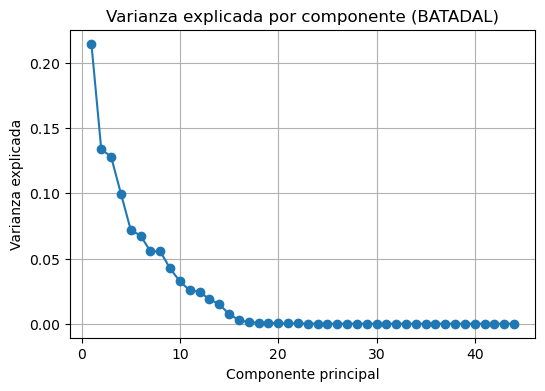

In [7]:
import cudf

# Cargar dataset BATADAL
gdf = cudf.read_parquet("modelos/data/BATADAL/data.parquet")

# Quitar label si existe
if "label" in gdf.columns:
    gdf = gdf.drop(columns=["label"])

# Seleccionar SOLO las columnas numéricas
num_cols = [c for c in gdf.columns if gdf[c].dtype.kind in ("i", "f")]
X = gdf[num_cols].astype("float32")

# Split train/test temporal simple
n = len(X)
cut = int(0.7 * n)
X_train, X_test = X.iloc[:cut], X.iloc[cut:]

# Entrenar PCAAnomalyDetector
det = PCAAnomalyDetector(n_components=None, threshold=0.997)
X_train_scaled = det.preprocess(X_train, retrain=True)
det.fit(X_train_scaled)

# Varianza explicada
expl_var = det.pca.explained_variance_ratio_
if hasattr(expl_var, "to_numpy"):
    expl_var = expl_var.to_numpy()
elif hasattr(expl_var, "get"):
    expl_var = expl_var.get()

# Gráfico de codo
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(range(1, len(expl_var)+1), expl_var, marker="o")
plt.xlabel("Componente principal")
plt.ylabel("Varianza explicada")
plt.title("Varianza explicada por componente (BATADAL)")
plt.grid(True)
plt.show()


### Interpretación de la curva de varianza explicada (BATADAL)

En este caso, la curva de **varianza explicada por componente** muestra que los **primeros componentes principales concentran gran parte de la información** del sistema:

- **Eje X** → número de componente principal.  
- **Eje Y** → porcentaje de varianza total que explica ese componente.  

La pendiente inicial elevada indica que las variables de BATADAL están **fuertemente correlacionadas** (ejemplo: caudales, presiones, temperaturas).  
Por tanto, unos pocos componentes bastan para capturar la mayor parte de la variabilidad del proceso.

La segunda curva, de **varianza acumulada**, permite responder a la pregunta:

> *“¿Con cuántos componentes conservo al menos el 95% de la información?”*

En la práctica, este análisis se usa para:
- **Reducir dimensionalidad** sin perder demasiada información.  
- Evitar sobreajuste al ruido manteniendo solo los componentes relevantes.  
- En el contexto de anomalías, **asegurarnos de que la reconstrucción con PCA capture el comportamiento normal**, de modo que los errores altos correspondan efectivamente a comportamientos anómalos.


In [8]:
import numpy as np

# 1) Varianza acumulada mínima
def select_by_variance_ratio(expl_var, threshold=0.95):
    """
    Devuelve el número mínimo de componentes necesarios para
    superar un porcentaje de varianza acumulada.
    """
    cum_var = np.cumsum(expl_var)
    return np.argmax(cum_var >= threshold) + 1

# 2) Kaiser rule (autovalores > 1)
def select_by_kaiser(eigenvalues):
    """
    Devuelve el número de componentes con autovalores > 1.
    Asume que los datos se han estandarizado previamente.
    """
    return np.sum(eigenvalues > 1)

# 3) Broken Stick Model
def select_by_broken_stick(expl_var):
    """
    Devuelve el número de componentes que superan
    el modelo de 'palito roto'.
    """
    n = len(expl_var)
    broken_stick = np.array([np.sum(1.0/np.arange(k, n+1)) / n for k in range(1, n+1)])
    return np.sum(expl_var > broken_stick)

# 4) Criterio de codo (elbow method)
def select_by_elbow(expl_var):
    """
    Devuelve el índice del codo usando el criterio geométrico:
    busca el punto más alejado de la línea entre el primero y el último.
    """
    n = len(expl_var)
    cum_var = np.cumsum(expl_var)
    # Coordenadas de los puntos
    points = np.column_stack((np.arange(1, n+1), cum_var))
    start, end = points[0], points[-1]
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)
    # Distancia perpendicular de cada punto a la recta
    distances = np.abs(np.cross(points - start, line_vec_norm))
    return np.argmax(distances) + 1


In [9]:
# Varianza explicada (como numpy array)
expl_var = det.pca.explained_variance_ratio_.to_numpy()
# Autovalores (eigenvalues) del PCA
eigenvalues = det.pca.explained_variance_.to_numpy()

print("Varianza ≥95%:", select_by_variance_ratio(expl_var, threshold=0.95))
print("Kaiser rule:", select_by_kaiser(eigenvalues))
print("Broken Stick:", select_by_broken_stick(expl_var))
print("Elbow method:", select_by_elbow(expl_var))


Varianza ≥95%: 12
Kaiser rule: 10
Broken Stick: 9
Elbow method: 13


### Selección automática de candidatos para *n_components*

Las cuatro funciones definidas anteriormente representan **criterios clásicos** para decidir el número óptimo de componentes principales en PCA:

1. **Varianza acumulada mínima** → selecciona el menor número de componentes que explica al menos un porcentaje prefijado de la varianza (ej. 95%).  
2. **Kaiser rule** → conserva solo los componentes con autovalores mayores que 1.  
3. **Broken Stick Model** → compara la varianza explicada con una distribución teórica aleatoria y descarta los que no la superan.  
4. **Criterio de codo (Elbow method)** → identifica el punto donde la curva de varianza acumulada comienza a aplanarse.  

Con estos métodos obtenemos un conjunto reducido de valores **candidatos a `n_components`**, que usaremos en los **experimentos de validación**.  
En lugar de probar todos los posibles valores (costoso y redundante), nos centraremos únicamente en aquellos que tienen una justificación estadística, optimizando así la búsqueda.


#### Métodos `predict` y `anomaly_score`

- `predict`: clasifica cada observación como **normal (0)** o **anómala (1)**, comparando su error de reconstrucción con el umbral.  
- `anomaly_score`: devuelve directamente el valor continuo del error de reconstrucción, útil para métricas como ROC AUC o curvas de precisión-recall.


In [10]:
def predict(self, X):
    errors = self._reconstruction_error(X)
    return cp.where(errors > self._threshold_value, 1, 0).get()

def anomaly_score(self, X):
    return self._reconstruction_error(X).get()

setattr(PCAAnomalyDetector, "predict", predict)
setattr(PCAAnomalyDetector, "anomaly_score", anomaly_score)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

@interact(
    n_components=widgets.IntSlider(value=5, min=1, max=30, step=1, description="n_components"),
    threshold=widgets.FloatSlider(
        value=3, min=1, max=200, step=0.1,  
        description="threshold"
    )
)
def explore_pca(n_components, threshold):
    # Reentrenamos PCA con los parámetros seleccionados
    det = PCAAnomalyDetector(n_components=n_components, threshold=threshold)
    X_train_scaled = det.preprocess(X_train, retrain=True)
    det.fit(X_train_scaled)
    X_test_scaled = det.preprocess(X_test, retrain=False)
    scores_test = det.anomaly_score(X_test_scaled)
    thr_val = det._threshold_value

    # Histograma de errores
    plt.figure(figsize=(7,4))
    plt.hist(scores_test, bins=50, color="skyblue", edgecolor="black")
    plt.axvline(thr_val, color="red", linestyle="--", linewidth=2, label=f"Umbral = {thr_val:.6f}")
    plt.xlabel("Error de reconstrucción (MSE)")
    plt.ylabel("Frecuencia")
    plt.title(f"Distribución de anomaly scores\n(n_components={n_components}, threshold={threshold:.6f})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 150)   # límite del eje Y para ver bien la cola
    plt.show()


interactive(children=(IntSlider(value=5, description='n_components', max=30, min=1), FloatSlider(value=3.0, de…

Aunque la lógica del PCA es relativamente simple, la implementación en GPU permite 
escalar el modelo a millones de observaciones con un tiempo de cómputo muy reducido.  
Esto convierte a `PCAAnomalyDetector` en un **baseline robusto y eficiente** 
para tareas de detección de anomalías en series temporales multivariantes.


### Exploración interactiva (PCA)

- **`n_components`**: controla cuántos componentes se usan en la reconstrucción.  
  - Pocos → más error, más anomalías.  
  - Muchos → menos error, menos anomalías.  

- **`threshold`**: fija el corte del error de reconstrucción.  
  - Bajo → más detecciones (pero más falsos positivos).  
  - Alto → menos detecciones (riesgo de falsos negativos).  

**Gráfica**  
- El histograma muestra los errores de reconstrucción en test.  
- La **línea roja** es el umbral: todo lo que queda a la derecha se marca como **anómalo**.  


## Conclusión  

El uso de **PCA para la detección de anomalías** constituye una aproximación sólida y eficiente, capaz de capturar la estructura dominante de los datos y detectar desviaciones significativas mediante el error de reconstrucción.  
Su simplicidad, rapidez e interpretabilidad lo convierten en un **baseline de referencia** frente al cual compararemos métodos más avanzados.  

No obstante, sus limitaciones inherentes —especialmente la **linealidad** y la **dependencia de la escala**— hacen necesario explorar técnicas más flexibles que puedan manejar relaciones no lineales y estructuras más complejas.  

En el **siguiente capítulo** se introduce el algoritmo **Isolation Forest**, un método basado en árboles de partición aleatoria que, a diferencia de PCA, no asume linealidad y ofrece un enfoque distinto para la identificación de anomalías en series temporales multivariantes.  


---

## Referencias

- Jolliffe, Ian T., and Jorge Cadima.  
**"Principal component analysis: a review and recent developments."** *Philosophical Transactions of the Royal Society A* 374.2065 (2016): 20150202.

- Shyu, Mei-Ling, et al.  
**"A novel anomaly detection scheme based on principal component classifier."** *Proceedings of the IEEE Foundations and New Directions of Data Mining Workshop*. 20